# Assignment 2

The following assignment is going to cover lectures 5, 6, 7 & 8.

## Broad Topics are

- Object Tracking
- Multi-Sensor Fusion
- Grasp Generation & Evalutaion
- Force Control

# Maximum Marks possible: [$60 = 30 + 20 + 10$]
If individual marks for a subpart are not specified assume equal marks for all the subparts within that section.

## How to Answer ?:
For theoretical questions make a markdown cell below each question/question-subpart and write the answer there. (yes handwritten solutions are allowed too but you need to be careful while linking it)
For coding questions write the answer at the designated position indicated by the question.

## Submission:
You have to submit the file assignment_2.ipynb with your answers into Moodle.

## Task 1: Tracking a Ball [Full Marks: $30 = 20 + 10$]


## Question1: Kalman Filter [Marks: $20$]

### Background
In this task, you will simulate the motion of a ball thrown in a vacuum and use a Kalman filter to track its trajectory. According to Newtonian physics, the motion of the ball in a constant gravitational field can be described by the following equations:

$$
\begin{aligned}
y &= \frac{g}{2}t^2 + v_{y0} t + y_0 \\
x &= v_{x0} t + x_0
\end{aligned}
$$

Where:
- $ g $ : gravitational acceleration constant
- $ t $ : time
- $ v_{x0}, v_{y0} $ : initial velocity components
- $ x_0, y_0 $ : initial position of the ball

If the ball is thrown with an initial velocity $v$ at an angle $\theta$ (above the horizontal), the initial velocity components can be computed as:
$$
\begin{aligned}
v_{x0} &= v \cos{\theta} \\
v_{y0} &= v \sin{\theta}
\end{aligned}
$$
Because we don't have real data we will start by writing a simulator for a ball. As always, we add a noise term independent of time so we can simulate noisy sensors.

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos
from numpy.random import randn
from filterpy.kalman import KalmanFilter

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, 
                 theta_deg=0., 
                 g=9.8, 
                 noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 
        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

So to create a trajectory starting at (0, 15) with a velocity of 100 m/s and an angle of 60° we would write:

```python
traj = BallTrajectory2D(x0=0, y0=15, velocity=100, theta_deg=60)
```
    
and then call `traj.step(t)` for each time step. Let's test this 

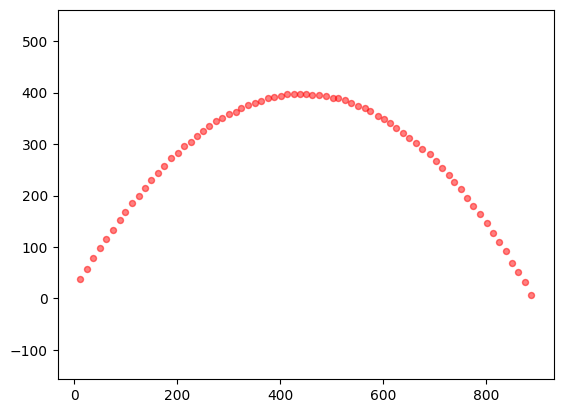

In [2]:
def test_ball_vacuum(noise):
    y = 15
    x = 0
    ball = BallTrajectory2D(x0=x, y0=y, 
                            theta_deg=60., velocity=100., 
                            noise=noise)
    t = 0
    dt = 0.25
    while y >= 0:
        x, y = ball.step(dt)
        t += dt
        if y >= 0:
            plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
         
    plt.axis('equal');
    plt.show()
    
#test_ball_vacuum([0, 0]) # plot ideal ball position
test_ball_vacuum([1, 1]) # plot with noise 

### Choose the State Variables
Given a ball moving in a vacuum, its motion is governed by the following discretized equations derived using Euler’s method with a time step $\Delta t$:

$$
\begin{aligned}
x_t &= x_{t-1} + v_{x(t-1)}\Delta t \\
v_{x t} &= v_{x(t-1)} \\
y_t &= y_{t-1} + v_{y(t-1)}\Delta t \\
v_{y t} &= v_{y(t-1)} - g\Delta t
\end{aligned}
$$

These equations assume constant horizontal velocity $v_x$ and vertical acceleration due to gravity $g$ only. We wish to implement a Kalman filter to track the ball’s state over time. The Kalman filter’s state prediction equation is:

$$
\mathbf{\bar{x}} = \mathbf{F}\mathbf{x} + \mathbf{B}\mathbf{u}
$$

- $\mathbf{F}$ represents the state transition matrix.
- $\mathbf{B}$ represents how control inputs affect the state.
- $\mathbf{u}$ is the control input vector, here corresponding to gravity.

We define the state vector as:

$$
\mathbf{x} = \begin{bmatrix} x & \dot{x} & y & \dot{y} \end{bmatrix}^\mathsf{T}
$$


### Designing the State Transition Function

The state transition function is represented by the matrix $\mathbf{F}$. Multiplying $\mathbf{F}$ by the previous state $\mathbf{x}$ yields the predicted state $\bar{\mathbf{x}}$:

$$
\bar{\mathbf{x}} = \mathbf{F}\mathbf{x}
$$

Given the state vector

$$
\mathbf{x} = \begin{bmatrix} x & \dot{x} & y & \dot{y} \end{bmatrix}^\mathsf{T},
$$

the discretized equations of motion (neglecting gravity here since it will be included as a control input) are:

$$
\begin{aligned}
\bar{x} &= x + \dot{x}\Delta t \\
\bar{\dot{x}} &= \dot{x} \\
\bar{y} &= y + \dot{y}\Delta t \\
\bar{\dot{y}} &= \dot{y}
\end{aligned}
$$

In matrix form, this corresponds to:

$$
\mathbf{F} = \begin{bmatrix}
1 & \Delta t & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 1
\end{bmatrix}.
$$


### Designing the Control Input Function

To incorporate gravitational acceleration into the Kalman filter, we utilize the control input term $\mathbf{Bu}$, where $\mathbf{u}$ represents the control input (gravity) and $\mathbf{B}$ represents how this input affects the state. The purpose is to account for the change in the state vector $\bar{\mathbf{x}}$ due to gravity between time steps.

From the discretized equations:

$$
\begin{aligned}
x_t &= x_{t-1} + v_{x(t-1)} \Delta t \\
v_{x t} &= v_{x(t-1)} \\
y_t &= y_{t-1} + v_{y(t-1)} \Delta t \\
v_{y t} &= v_{y(t-1)} - g \Delta t
\end{aligned}
$$

It follows that gravity affects only the vertical velocity component $\dot{y}$. Therefore, we require:

$$
\mathbf{B}\mathbf{u} = \begin{bmatrix}0 \\ 0 \\ 0 \\ -g \Delta t \end{bmatrix}.
$$

The exact structure of $\mathbf{B}$ and $\mathbf{u}$ is somewhat flexible, as long as their product yields the desired change in state. One suitable choice, adhering to the notion that $\mathbf{u}$ should contain the control input itself (i.e., $-g$) and that $\mathbf{B}$ should incorporate the time step, is:

$$
\mathbf{B} = \begin{bmatrix}0 \\ 0 \\ 0 \\ \Delta t \end{bmatrix}, \quad
\mathbf{u} = \begin{bmatrix}-g\end{bmatrix}.
$$

This formulation clearly separates the control input ($-g$) from the time step ($\Delta t$), ensuring that time remains a parameter of $\mathbf{B}$, the control function, rather than being embedded directly into $\mathbf{u}$.


### Design the Measurement Function

The measurement function defines how we go from the state variables to the measurements using the equation $\mathbf z = \mathbf{Hx}$. We will assume that we have a sensor that provides us with the position of the ball in (x,y), but cannot measure velocities or accelerations. Therefore our function must be:

$$
\begin{bmatrix}z_x \\ z_y \end{bmatrix}= 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix} 
\begin{bmatrix}
x \\
\dot x \\
y \\
\dot y \end{bmatrix}$$

where

$$\mathbf H = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}$$

### Design the Measurement Noise Matrix

As with the robot, we will assume that the error is independent in $x$ and $y$. In this case we will start by assuming that the measurement errors in x and y are 0.5 meters squared. Hence,

$$\mathbf R = \begin{bmatrix}0.5&0\\0&0.5\end{bmatrix}$$

### Design the Process Noise Matrix

We are assuming a ball moving in a vacuum, so there should be no process noise. We have 4 state variables, so we need a $4{\times}4$ covariance matrix:

$$\mathbf Q = \begin{bmatrix}0&0&0&0\\0&0&0&0\\0&0&0&0\\0&0&0&0\end{bmatrix}$$

### Design the Initial Conditions

We already performed this step when we tested the state transition function. Recall that we computed the initial velocity for $x$ and $y$ using trigonometry, and set the value of $\mathbf x$ with:

```python
omega = radians(omega)
vx = cos(omega) * v0
vy = sin(omega) * v0

f1.x = np.array([[x, vx, y, vy]]).T
```
    
With all the steps done we are ready to implement our filter and test it. First, the implementation:

In [4]:
from math import sin, cos, radians

def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.):

    ########### TODO ##################
    # Initialize Kalman filter: 4 states (x, vx, y, vy), 2 measurements (x, y), 1 control input (gravity)
    kf = KalmanFilter(dim_x=4, dim_u=1, dim_z=2)

    # State transition matrix F
    # States: x, vx, y, vy
    # x   = x_previous + vx*dt
    # vx  = vx_previous
    # y   = y_previous + vy*dt
    # vy  = vy_previous
    kf.F = np.array([
        [1, dt, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, dt],
        [0, 0, 0, 1],
    ])
    

    # Measurement function H
    # We measure only position (x, y), no velocities
    kf.H = np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ])

    # Control input matrix B
    # Only vy is affected by control input (gravity)
    # B maps the control input (u = -g) to a change in vy:
    # vy_new = vy_old + (-g)*dt, so we place dt in the vy row.
    kf.B = np.array([[0, 0, 0, dt]]).T

    #####################################
    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0
    kf.x = np.array([[x, vx, y, vy]]).T
    return kf

Now we will test the filter by generating measurements for the ball using the ball simulation class.

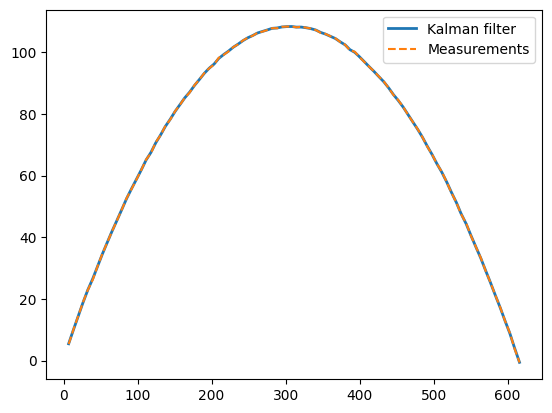

In [17]:
def track_ball_vacuum(dt):
    global kf
    x, y = 0., 1.
    theta = 35.  # launch angle
    v0 = 80.
    g = np.array([[-9.8]])  # gravitational constant
    ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, 
                            noise=[.2, .2])
    kf = ball_kf(x, y, theta, v0, dt)

    t = 0
    xs, ys = [], []
    meas_xs, meas_ys = [], []
    while kf.x[2] > 0:
        ######################## TODO ############################
        # Predict the next state given the control input (gravity)
        # Obtain new noisy measurement from the simulated ball
        # Update the Kalman filter with the new measurement
        # Store the results
        ##########################################################
        kf.predict(u=g)
        (meas_x, meas_y) = ball.step(dt)
        meas_xs.append(meas_x)
        meas_ys.append(meas_y)
        kf.update(np.array([[meas_x, meas_y],
                            ]).T)
        xs.append(kf.x[0])
        ys.append(kf.x[2])

        ### I added meas_xs and meas_ys as well as the plot for p1 outside the scope of the TODO as it was causing errors
        ### I couldn't do it within the scope of the while loop



        ##########################################################
    p2, = plt.plot(xs, ys, lw=2)
    p1, = plt.plot(meas_xs, meas_ys, ls='dashed')
    plt.legend([p2, p1], ['Kalman filter', 'Measurements'],
               scatterpoints=1)
    plt.show()
track_ball_vacuum(dt=1./10)

We see that the Kalman filter reasonably tracks the ball. However, as already explained, this is a trivial example because we have no process noise. We can predict trajectories in a vacuum with arbitrary precision; using a Kalman filter in this example is a needless complication. A least squares curve fit would give identical results.

### Tracking a Ball in Air

For this problem, we assume that we are tracking a ball travelling through the Earth's atmosphere. The path of the ball is influenced by wind, drag, and the rotation of the ball. We will assume that our sensor is a camera; code that we will not implement will perform some type of image processing to detect the position of the ball. This is typically called *blob detection* in computer vision. However, the image processing code is not perfect; in any given frame it is possible to either detect no blob or to detect spurious blobs that do not correspond to the ball. Finally, we will not assume that we know the starting position, angle, or rotation of the ball; the tracking code will have to initiate tracking based on the measurements that are provided. The main simplification that we are making here is a 2D world; we assume that the ball is always travelling orthogonal to the plane of the camera's sensor. We have to make that simplification at this point because we have not discussed how we might extract 3D information from a camera, which provides only 2D data. 

### Implementing Air Drag

Our first step is to implement the math for a ball moving through air. There are several treatments available. A robust solution takes into account issues such as ball roughness (which affects drag non-linearly depending on velocity), the Magnus effect (spin causes one side of the ball to have a higher velocity relative to the air vs the opposite side, so the coefficient of drag differs on opposite sides), the effect of lift, humidity, air density, and so on. I assume the reader is not interested in the details of ball physics, and so will restrict this treatment to the effect of air drag on a non-spinning baseball. I will use the math developed by Nicholas Giordano and Hisao Nakanishi in *Computational Physics*  [1997]. This treatment does not take all the factors into account. The most detailed treatment is by Alan Nathan on his website at http://baseball.physics.illinois.edu/index.html. I use his math in my work in computer vision, but I do not want to get distracted by a more complicated model.

**Important**: Before I continue, let me point out that you will not have to understand this next piece of physics to proceed with the Kalman filter. My goal is to create a reasonably accurate behaviour of a baseball in the real world so that we can test how our Kalman filter performs with real-world behaviour. In real-world applications, it is usually impossible to completely model the physics of a real-world system, and we make do with a process model that incorporates large-scale behaviours. We then tune the measurement noise and process noise until the filter works well with our data. There is a real risk to this; it is easy to finely tune a Kalman filter so it works perfectly with your test data, but performs badly when presented with slightly different data. This is perhaps the hardest part of designing a Kalman filter, and why it gets referred to with terms such as 'black art'. 

I dislike books that implement things without explanation, so I will now develop the physics for a ball moving through air. Move on past the implementation of the simulation if you are not interested. 

A ball moving through air encounters wind resistance. This imparts a force on the wall, called *drag*, which alters the flight of the ball. In Giordano, this is denoted as

$$F_{drag} = -B_2v^2$$

where $B_2$ is a coefficient derived experimentally, and $v$ is the velocity of the object. $F_{drag}$ can be factored into $x$ and $y$ components with

$$\begin{aligned}
F_{drag,x} &= -B_2v v_x\\
F_{drag,y} &= -B_2v v_y
\end{aligned}$$

If $m$ is the mass of the ball, we can use $F=ma$ to compute the acceleration as

$$\begin{aligned} 
a_x &= -\frac{B_2}{m}v v_x\\
a_y &= -\frac{B_2}{m}v v_y
\end{aligned}$$

Giordano provides the following function for $\frac{B_2}{m}$, which takes air density, the cross-section of a baseball, and its roughness into account. Understand that this is an approximation based on wind tunnel tests and several simplifying assumptions. It is in SI units: velocity is in meters/sec and time is in seconds.

$$\frac{B_2}{m} = 0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}}$$

Starting with this Euler discretization of the ball path in a vacuum:
$$\begin{aligned}
x &= v_x \Delta t \\
y &= v_y \Delta t \\
v_x &= v_x \\
v_y &= v_y - 9.8 \Delta t
\end{aligned}
$$

We can incorporate this force (acceleration) into our equations by incorporating $accel * \Delta t$ into the velocity update equations. We should subtract this component because drag will reduce the velocity. The code to do this is quite straightforward, we just need to break out the force into $x$ and $y$ components. 

I will not belabour this issue further because computational physics is beyond the scope of this book. Recognize that a higher fidelity simulation would require incorporating things like altitude, temperature, ball spin, and several other factors. The aforementioned work by Alan Nathan covers this if you are interested. My intent here is to impart some real-world behaviour into our simulation to test how our simpler prediction model used by the Kalman filter reacts to this behaviour. Your process model will never exactly model what happens in the world, and a large factor in designing a good Kalman filter is carefully testing how it performs against real-world data. 

The code below computes the behaviour of a baseball in the air, at sea level, in the presence of wind. I plot the same initial hit with no wind, and then with a tail wind at 10 mph. Baseball statistics are universally done in US units, and we will follow suit here (http://en.wikipedia.org/wiki/United_States_customary_units). Note that the velocity of 110 mph is a typical exit speed for a baseball for a home run hit.

In [ ]:
from math import sqrt, exp

def mph_to_mps(x):
    return x * .447

def drag_force(velocity):
    """ Returns the force on a baseball due to air drag at
    the specified velocity. Units are SI"""

    return velocity * (0.0039 + 0.0058 / 
            (1. + exp((velocity-35.)/5.)))

v = mph_to_mps(110.)
x, y = 0., 1.
dt = .1
theta = radians(35)

def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel*cos(launch_angle)
    v_y = vel*sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x*dt
        y += v_y*dt

        # force due to air drag    
        velocity = sqrt((v_x-v_wind)**2 + v_y**2)    
        F = drag_force(velocity)

        # euler's equations for vx and vy
        v_x = v_x - F*(v_x-v_wind)*dt
        v_y = v_y - 9.8*dt - F*v_y*dt
        
        xs.append(x)
        ys.append(y)
    
    return xs, ys
        
x, y = solve(x=0, y=1, vel=v, v_wind=0, launch_angle=theta)
p1 = plt.scatter(x, y, color='blue', label='no wind')
wind = mph_to_mps(10)
x, y = solve(x=0, y=1, vel=v, v_wind=wind, launch_angle=theta)
p2 = plt.scatter(x, y, color='green', marker="v", 
                 label='10mph wind')
plt.legend(scatterpoints=1);
plt.show()

We can easily see the difference between the trajectory in a vacuum and the air. I used the same initial velocity and launch angle in the ball in the vacuum section above. We computed that the ball in a vacuum would travel over 240 meters (nearly 800 ft). In the air, the distance is just over 120 meters or roughly 400 ft. 400ft is a realistic distance for a well-hit home run ball, so we can be confident that our simulation is reasonably accurate.

Without further ado, we will create a ball simulation that uses the math above to create a more realistic ball trajectory. I will note that the nonlinear behaviour of drag means that there is no analytic solution to the ball position at any point in time, so we need to compute the position step-wise. I use Euler's method to propagate the solution; the use of a more accurate technique such as Runge-Kutta is left as an exercise for the reader. That modest complication is unnecessary for what we are doing because the accuracy difference between the techniques will be small for the time steps we will be using. 

In [7]:
class BaseballPath:
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0, 1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respectively to 
                         ground plane
        velocity_ms      speed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x, y)
        """
        
        omega = radians(launch_angle_deg)
        self.v_x = velocity_ms * cos(omega)
        self.v_y = velocity_ms * sin(omega)

        self.x = x0
        self.y = y0
        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x, y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt

        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

Now we can test the Kalman filter against measurements created by this model.

In [ ]:
x, y = 0, 1.

theta = 35. # launch angle
v0 = 50.
dt = 1/10.   # time step
g = np.array([[-9.8]])

plt.figure()
ball = BaseballPath(x0=x, y0=y, launch_angle_deg=theta,
                    velocity_ms=v0, noise=[.3,.3])
f1 = ball_kf(x, y, theta, v0, dt, r=1.)
f2 = ball_kf(x, y, theta, v0, dt, r=10.)
t = 0
xs, ys = [], []
xs2, ys2 = [], []

while f1.x[2] > 0:
    t += dt
    x, y = ball.update(dt)
    z = np.array([[x, y]]).T

    f1.update(z)
    f2.update(z)
    xs.append(f1.x[0])
    ys.append(f1.x[2])
    xs2.append(f2.x[0])
    ys2.append(f2.x[2])    
    f1.predict(u=g) 
    f2.predict(u=g)
    
    p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)

p2, = plt.plot(xs, ys, 'g', lw=2)
p3, = plt.plot(xs2, ys2, 'b',lw=4)
plt.legend([p1, p2, p3], 
           ['Measurements', 'Filter(R=0.5)', 'Filter(R=10)'],
           loc='best', scatterpoints=1);
plt.show()

I have plotted the output of two different Kalman filter settings. The measurements are depicted as green circles, a Kalman filter with R=0.5 as a thin green line, and a Kalman filter with R=10 as a thick blue line. These R values are chosen merely to show the effect of measurement noise on the output, they are not intended to imply a correct design.

We can see that neither filter does very well. At first, both track the measurements well, but as time continues they both diverge. This happens because the state model for air drag is nonlinear and the Kalman filter assumes that it is linear. If you recall our discussion about nonlinearity in the g-h filter chapter we showed why a g-h filter will always lag behind the acceleration of the system. We see the same thing here - the acceleration is negative, so the Kalman filter consistently overshoots the ball position. There is no way for the filter to catch up so long as the acceleration continues, so the filter will continue to diverge.

What can we do to improve this? The best approach is to perform the filtering with a nonlinear Kalman filter, and we will do this in subsequent chapters. However, there is also what I will call an 'engineering' solution to this problem. Our Kalman filter assumes that the ball is in a vacuum, and thus that there is no process noise. However, since the ball is in air the atmosphere imparts a force on the ball. We can think of this force as process noise. This is not a particularly rigorous thought; for one thing, this force is anything but Gaussian. Secondly, we can compute this force, so throwing our hands up and saying 'It's random' will not lead to an optimal solution. But let's see what happens if we follow this line of thought.

The following code implements the same Kalman filter as before, but with a non-zero process noise. I plot two examples, one with `Q=.1`, and one with `Q=0.01`.

In [ ]:
def plot_ball_with_q(q, r=1., noise=0.3):
    x, y = 0., 1.
    theta = 35. # launch angle
    v0 = 50.
    dt = 1/10.   # time step
    g = np.array([[-9.8]])

    ball = BaseballPath(x0=x, 
                        y0=y, 
                        launch_angle_deg=theta, 
                        velocity_ms=v0, 
                        noise=[noise,noise])
    f1 = ball_kf(x, y, theta, v0, dt, r=r, q=q)
    t = 0
    xs, ys = [], []

    while f1.x[2] > 0:
        t += dt
        x, y = ball.update(dt)
        z = np.array([[x, y]]).T

        f1.update(z)
        xs.append(f1.x[0])
        ys.append(f1.x[2]) 
        f1.predict(u=g) 

        p1 = plt.scatter(x, y, c='r', marker='.', s=75, alpha=0.5)

    p2, = plt.plot(xs, ys, lw=2, color='b')
    plt.legend([p1, p2], ['Measurements', 'Kalman filter'])
    plt.show()

plot_ball_with_q(0.01)
plot_ball_with_q(0.1)

The second filter tracks the measurements fairly well. There appears to be a bit of lag, but very little.

Is this a good technique? Usually not, but it depends. Here the nonlinearity of the force on the ball is fairly constant and regular. Assume we are trying to track an automobile - the accelerations will vary as the car changes speeds and turns. When we make the process noise higher than the actual noise in the system the filter will opt to weigh the measurements higher. If you don't have a lot of noise in your measurements this might work for you. However, consider this next plot where I have increased the noise in the measurements.

In [ ]:
plot_ball_with_q(0.01, r=3, noise=3.)
plot_ball_with_q(0.1, r=3, noise=3.)

This output is terrible. The filter has no choice but to give more weight to the measurements than the process (prediction step), but when the measurements are noisy the filter output will just track the noise. This inherent limitation of the linear Kalman filter is what led to the development of nonlinear versions of the filter.

With that said, it is certainly possible to use the process noise to deal with small nonlinearities in your system. This is part of the 'black art' of Kalman filters. Our model of the sensors and the system are never perfect. Sensors are non-Gaussian and our process model is never perfect. You can mask some of this by setting the measurement errors and process errors higher than their theoretically correct values, but the trade-off is a non-optimal solution. Certainly, it is better to be non-optimal than to have your Kalman filter diverge. However, as we can see in the graphs above, it is easy for the output of the filter to be very bad. It is also very common to run many simulations and tests and to end up with a filter that performs very well under those conditions. Then, when you use the filter on real data the conditions are slightly different and the filter ends up performing terribly. 

For now we will set this problem aside, as we are misapplying the Kalman filter in this example. We will revisit this problem in subsequent chapters to see the effect of using various nonlinear techniques. In some domains, you will be able to get away with using a linear Kalman filter for a nonlinear problem, but usually you will have to use one or more of the techniques you will learn in the rest of this book.

### Question 2: Particle Filter [Marks: $10$]

Now following the lecture, we will implement a particle filter for the baseball trajectory tracking.
Tune the parameters **motion_noise_std** and **measurement_noise** to get a good result. And explain why you chose the parameters you did.

In [ ]:
class BaseballParticleFilter:
    def __init__(self, num_particles, x0, y0, launch_angle_deg, velocity_ms, dt, 
                 measurement_noise=(1.0, 1.0),
                 motion_noise_std=0.1):
        """Initialize particle filter for baseball trajectory tracking
        
        Args:
            num_particles: Number of particles to use
            x0, y0: Initial position
            launch_angle_deg: Launch angle in degrees 
            velocity_ms: Initial velocity in m/s
            dt: Time step
            noise: Measurement noise in (x,y)
        """
        self.num_particles = num_particles
        self.dt = dt
        self.measurement_noise = measurement_noise
        self.motion_noise_std = motion_noise_std
        
        # Initialize particles at same starting state with small random noise
        omega = radians(launch_angle_deg)
        v_x = velocity_ms * cos(omega)
        v_y = velocity_ms * sin(omega)
        
        # Each particle has state [x, vx, y, vy]
        self.particles = np.zeros((num_particles, 4))
        for i in range(num_particles):
            self.particles[i] = [
                x0 + randn()*0.1, 
                v_x + randn()*0.1,
                y0 + randn()*0.1, 
                v_y + randn()*0.1
            ]
            
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, g=-9.81):
        """Propagate particles through motion model with drag"""
        for i in range(self.num_particles):
            # Extract state
            x, vx, y, vy = self.particles[i]
            
            # Update positions (Euler integration)
            x += vx * self.dt
            y += vy * self.dt
            
            vx = vx 
            vy = vy + g*self.dt
            
            # Add process noise
            x += randn() * self.motion_noise_std
            y += randn() * self.motion_noise_std
            vx += randn() * self.motion_noise_std  
            vy += randn() * self.motion_noise_std
            
            self.particles[i] = [x, vx, y, vy]

    def update(self, measurement):
        """Update weights based on measurement likelihood"""
        for i in range(self.num_particles):
            # Calculate likelihood of measurement given particle position
            x_diff = measurement[0] - self.particles[i,0]
            y_diff = measurement[1] - self.particles[i,2]
            
            # Gaussian likelihood
            likelihood = exp(-0.5 * (
                (x_diff/self.measurement_noise[0])**2 + 
                (y_diff/self.measurement_noise[1])**2
            ))
            
            self.weights[i] *= likelihood

        # Normalize weights
        self.weights += 1e-300  # Avoid division by zero
        self.weights /= sum(self.weights)

    def resample(self):
        """Resample particles based on weights"""
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1.0
        
        # Generate random numbers
        positions = np.random.random(self.num_particles)
        
        # Resample particles
        new_particles = np.zeros((self.num_particles, 4))
        for i in range(self.num_particles):
            idx = np.searchsorted(cumsum, positions[i])
            new_particles[i] = self.particles[idx]
            
        self.particles = new_particles
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        """Return weighted mean of particles as current estimate"""
        mean = np.average(self.particles, weights=self.weights, axis=0)
        return mean[0], mean[2]  # Return x,y position
    

# reinitialize the ball
x, y = 0, 1.

theta = 35. # launch angle
v0 = 50.
dt = 1/10.   # time step
g = np.array([[-9.8]])

ball = BaseballPath(x0=x, y0=y, launch_angle_deg=theta,
                    velocity_ms=v0, noise=[.3,.3])

# Initialize filter
pf = BaseballParticleFilter(
    num_particles=1000,
    x0=0, y0=1,
    launch_angle_deg=35,
    velocity_ms=50,
    dt=0.1,
    #################TODO#####################
    ## your parameters here
    measurement_noise=[0.5, 0.5],
    motion_noise_std=0.7
    ## your parameters here
    ## your explanation here
    #########################################
)

# Track trajectory and plot
xs, ys = [], []
measurements_x, measurements_y = [], []

while True:
    # Get measurement from ball simulation
    x, y = ball.update(dt)
    measurements_x.append(x)
    measurements_y.append(y)
    
    # Predict and update particle filter
    pf.predict()
    pf.update([x, y])
    pf.resample()
    
    # Get estimate and store
    x_est, y_est = pf.estimate()
    xs.append(x_est)
    ys.append(y_est)
    
    # Stop when ball hits ground
    if y_est <= 0:
        break

# Final plot
plt.figure(figsize=(10, 8))

# Plot particles
plt.scatter(pf.particles[:,0], pf.particles[:,2], 
           color='gray', s=1, label='Particles')

# Plot measurements
plt.scatter(measurements_x, measurements_y, 
           color='r', alpha=0.5, label='Measurements')

# Plot estimates
plt.plot(xs, ys, 'b-', linewidth=2, label='Particle Filter Estimate')

plt.grid(True)
plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Baseball Trajectory Tracking with Particle Filter')

plt.show()

We can see that the particle filter can track the trajectory of the baseball.

However, due to the very wrong motion model, the particle filter is not able to track the trajectory very well.

We are saying even though the position capture is quite well, but the trajectory is not smooth at all.

Let's try to improve the motion model. and see if we can get a better result.

You need to include the nonlinear drag force in the motion model. And tune the parameters to get a good result.

Here we mean to get a smooth trajectory.

In [ ]:
class BaseballParticleFilter:
    def __init__(self, num_particles, x0, y0, launch_angle_deg, velocity_ms, dt, 
                 measurement_noise=(1.0, 1.0),
                 motion_noise_std=0.1):
        """Initialize particle filter for baseball trajectory tracking
        
        Args:
            num_particles: Number of particles to use
            x0, y0: Initial position
            launch_angle_deg: Launch angle in degrees 
            velocity_ms: Initial velocity in m/s
            dt: Time step
            noise: Measurement noise in (x,y)
        """
        self.num_particles = num_particles
        self.dt = dt
        self.measurement_noise = measurement_noise
        self.motion_noise_std = motion_noise_std
        
        # Initialize particles at same starting state with small random noise
        omega = radians(launch_angle_deg)
        v_x = velocity_ms * cos(omega)
        v_y = velocity_ms * sin(omega)
        
        # Each particle has state [x, vx, y, vy]
        self.particles = np.zeros((num_particles, 4))
        for i in range(num_particles):
            self.particles[i] = [
                x0 + randn()*0.1, 
                v_x + randn()*0.1,
                y0 + randn()*0.1, 
                v_y + randn()*0.1
            ]
            
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, g=-9.81):
        """Propagate particles through motion model with drag"""
        for i in range(self.num_particles):
            # Extract state
            x, vx, y, vy = self.particles[i]
            
            # First update velocities
            # Calculate velocity and drag force
            
            ########### TODO ##################

            ###############################
            
            # Update velocities with drag and gravity
            v_x_new = vx - drag_force * vx * self.dt  # Drag force in x direction
            v_y_new = vy + g * self.dt - drag_force * vy * self.dt  # Gravity + drag force in y direction
            
            # Then update positions using new velocities
            x_new = x + v_x_new * self.dt
            y_new = y + v_y_new * self.dt
            
            # Add process noise
            x_new += randn() * self.motion_noise_std
            y_new += randn() * self.motion_noise_std
            v_x_new += randn() * self.motion_noise_std
            v_y_new += randn() * self.motion_noise_std
            
            self.particles[i] = [x_new, v_x_new, y_new, v_y_new]

    def update(self, measurement):
        """Update weights based on measurement likelihood"""
        for i in range(self.num_particles):
            # Calculate likelihood of measurement given particle position
            x_diff = measurement[0] - self.particles[i,0]
            y_diff = measurement[1] - self.particles[i,2]
            
            # Gaussian likelihood
            likelihood = exp(-0.5 * (
                (x_diff/self.measurement_noise[0])**2 + 
                (y_diff/self.measurement_noise[1])**2
            ))
            
            self.weights[i] *= likelihood

        # Normalize weights
        self.weights += 1e-300  # Avoid division by zero
        self.weights /= sum(self.weights)

    def resample(self):
        """Resample particles based on weights"""
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1.0
        
        # Generate random numbers
        positions = np.random.random(self.num_particles)
        
        # Resample particles
        new_particles = np.zeros((self.num_particles, 4))
        for i in range(self.num_particles):
            idx = np.searchsorted(cumsum, positions[i])
            new_particles[i] = self.particles[idx]
            
        self.particles = new_particles
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        """Return weighted mean of particles as current estimate"""
        mean = np.average(self.particles, weights=self.weights, axis=0)
        return mean[0], mean[2]  # Return x,y position
    

# reinitialize the ball
x, y = 0, 1.

theta = 35. # launch angle
v0 = 50.
dt = 1/10.   # time step
g = np.array([[-9.8]])

ball = BaseballPath(x0=x, y0=y, launch_angle_deg=theta,
                    velocity_ms=v0, noise=[.3,.3])

# Initialize filter
pf = BaseballParticleFilter(
    num_particles=1000,
    x0=0, y0=1,
    launch_angle_deg=35,
    velocity_ms=50,
    dt=0.1,
    ## your parameters here
    measurement_noise=[0.3, 0.3],
    motion_noise_std=0.1
    ## your parameters here
    ## your explanation here
)

# Track trajectory and plot
xs, ys = [], []
measurements_x, measurements_y = [], []

while True:
    # Get measurement from ball simulation
    x, y = ball.update(dt)
    measurements_x.append(x)
    measurements_y.append(y)
    
    # Predict and update particle filter
    pf.predict()
    pf.update([x, y])
    pf.resample()
    
    # Get estimate and store
    x_est, y_est = pf.estimate()
    xs.append(x_est)
    ys.append(y_est)
    
    # Stop when ball hits ground
    if y_est <= 0:
        break

# Final plot
plt.figure(figsize=(10, 8))

# Plot particles
plt.scatter(pf.particles[:,0], pf.particles[:,2], 
           color='gray', s=1, label='Particles')

# Plot measurements
plt.scatter(measurements_x, measurements_y, 
           color='r', alpha=0.5, label='Measurements')

# Plot estimates
plt.plot(xs, ys, 'b-', linewidth=2, label='Particle Filter Estimate')

plt.grid(True)
plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Baseball Trajectory Tracking with Particle Filter')

plt.show()

## Task 2: Grasping objects. [Full Marks: $20 = 5 + 7 + 2 + 6$]

The goal of this task will be to implement a grasping pipeline for grasping an object in 3D space.

We will not assume any obstacles for this case and focus our attention on grasp-sampling and grasp-scoring.

In [ ]:
import open3d as o3d
import numpy as np

from typing import Tuple, Sequence, Optional

from utils import visualize_3d_objs, create_grasp_mesh

### Let's start by loading object meshes 

In [4]:
def get_mesh_by_name(object_type: str,
                     desired_vol: float = 0.000144) -> Tuple[o3d.geometry.TriangleMesh,
                                                    np.ndarray, float]:
    dataset_map = {
        'armadillo': o3d.data.ArmadilloMesh,
        'bunny': o3d.data.BunnyMesh,
        'avocado': o3d.data.AvocadoModel
    }

    if object_type not in dataset_map:
        raise ValueError(f"Unsupported object type. Choose from: {list(dataset_map.keys())}")

    print(f"Loading {object_type} mesh from Open3D dataset...")
    mesh = dataset_map[object_type]()

    # Read and process mesh
    loaded_mesh = o3d.io.read_triangle_mesh(mesh.path)
    bbox = loaded_mesh.get_axis_aligned_bounding_box()
    size = bbox.get_extent()
    width, height, depth = size
    print((f"Mesh Dimensions Original:\n"
           f"- Width: {width:.2f}\n"
           f"- Height: {height:.2f}\n"
           f"- Depth: {depth:.2f}"))
    volume = width * height * depth
    scale_factor = np.cbrt(desired_vol / volume)
    loaded_mesh.scale(scale_factor, center=loaded_mesh.get_center())
    loaded_mesh.compute_vertex_normals() # for fancy visualization
    center = np.asarray(loaded_mesh.get_center())
    bbox = loaded_mesh.get_axis_aligned_bounding_box()
    size = bbox.get_extent()
    width, height, depth = size
    print((f"Mesh Dimensions After Scaling:\n"
           f"- Width: {width:.2f}\n"
           f"- Height: {height:.2f}\n"
           f"- Depth: {depth:.2f}"))

    return loaded_mesh, center, scale_factor

### Let's visualize how this thing looks

The $x, y, z$ axis will be rendered as red, green, and blue arrows respectively.

In [ ]:

obj_name = 'avocado'
mesh, center, scale = get_mesh_by_name(obj_name)

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
            size=0.1, origin=center)

visualize_3d_objs([mesh, coordinate_frame])

**Make sure you close the visualizer before moving forward.**

Now that we have the object and the coordinate frame, let's create a grasp.

In [24]:
# Remember everything here is in meters
off_center = center + np.array([0, 0, 0.05])
grasp = create_grasp_mesh(center_point=off_center)
# grasp is multiple meshes, so make sure to unpack it
visualize_3d_objs([mesh, coordinate_frame, *grasp])

### Question 1: Complete the function to sample grasps [Marks: $5$]

We will sample grasps around a target point in a sphere.

Imagine the grasps getting sampled around a sphere where we can take any valid point inside the sphere.

We can sample by leveraging polar coordinates $\theta, \phi, r$ for our sampling procedure.

In the context of this question translation just means distance from center.

In [7]:
def sample_grasps(
    center_point: np.ndarray,
    num_grasps: int,
    offset: float = 0.1,
) -> Sequence[Tuple[np.ndarray, np.ndarray]]:
    """
    Generates multiple random grasp poses around a given point cloud.

    Args:
        center: Center around which to sample grasps.
        num_grasps: Number of random grasp poses to generate
        offset: Maximum distance offset from the center (meters)

    Returns:
        list: List of rotations and Translations
    """

    grasp_poses_list = []
    for idx in range(num_grasps):
        # Sample a grasp center and rotation of the grasp
        # Sample a random vector in R3 for axis angle representation
        # Return the rotation as rotation matrix + translation
        # Translation implies translation from a center point
        ############################TODO############################

        ######################################################
        assert R.shape == (3, 3)
        assert grasp_center.shape == (3,)
        grasp_poses_list.append((R, grasp_center))

    return grasp_poses_list

### Now using the sampled poses let's create a lot of grasp meshes.

In [25]:
sample_grasp_lists = sample_grasps(center_point=center, num_grasps=100, offset=0.1)

#######################TODO######################


##################################################
vis_meshes = [mesh, coordinate_frame]
for grasp_mesh in all_grasp_meshes:
    vis_meshes.extend(grasp_mesh)

visualize_3d_objs(vis_meshes)

### Question 2: Now we will check collision between two meshes using point clouds [Marks: 7]

Use a KD tree to check if there is a collision between the two point-clouds.

A collision is defined if there exists more than `num_collisions` set of two points one from each of the point-clouds which are less than or equal to `tolerance` away from each other.

You can use the KD Tree from `o3d.geometry.KDTreeFlann`

In [ ]:
# Helper function to check if two meshes are equal
def are_meshes_equal(mesh1: o3d.geometry.TriangleMesh,
                     mesh2: o3d.geometry.TriangleMesh) -> bool:
    # Compare vertices
    if not np.array_equal(np.asarray(mesh1.vertices), np.asarray(mesh2.vertices)):
        print("Vertex Problem")
        return False
    
    # Compare triangles
    if not np.array_equal(np.asarray(mesh1.triangles), np.asarray(mesh2.triangles)):
        print("Triangle Problem")
        return False
    
    return True

In [9]:
def check_grasp_collision(
    grasp_meshes: Sequence[o3d.geometry.TriangleMesh],
    object_mesh: o3d.geometry.TriangleMesh,
    num_colisions: int = 10,
    tolerance: float = 0.00001) -> bool:
    """
    Checks for collisions between a gripper grasp pose and target object
    using point cloud sampling.

    Args:
        grasp_meshes: List of mesh geometries representing the gripper components
        object_mesh: Triangle mesh of the target object
        num_collisions: Threshold on how many points to check
        tolerance: Distance threshold for considering a collision (in meters)

    Returns:
        bool: True if collision detected between gripper and object, False otherwise
    """
    # Combine gripper meshes
    combined_gripper = o3d.geometry.TriangleMesh()
    for mesh in grasp_meshes:
        combined_gripper += mesh

    # Sample points from both meshes
    num_points = 5000 # Subsample both meshes to this many points
    #######################TODO#######################

    ##################################################
    # Build KDTree for object points
    is_collision = False
    #######################TODO#######################


    #######################TODO#######################

    return is_collision

### Let's visualize all gripper poses which are not in collision

In [26]:
import copy
vis_meshes = [mesh, coordinate_frame]
for grasp_mesh in all_grasp_meshes:
    first_finger = copy.copy(grasp_mesh[0])
    if not check_grasp_collision(grasp_mesh, mesh):
        vis_meshes.extend(grasp_mesh)
    # to verify that the mesh is not modified
    assert are_meshes_equal(first_finger, grasp_mesh[0])

visualize_3d_objs(vis_meshes)

**You might still be seeing a lot of gripper positions which are in the way.**

### Question 3: Let's create a filter which removes all grasps more than a certain distance away. [Marks: $2$]

Add your code here in the following two cells

In [11]:
def grasp_dist_filter(center_grasp: np.ndarray,
                      mesh_center: np.ndarray,
                      tolerance: float = 0.05)->bool:
    is_within_range = False
    #######################TODO#######################

    ##################################################
    return is_within_range

**Visualize all grasps here that are within range**

In [27]:
vis_meshes = [mesh, coordinate_frame]
for pose, grasp_mesh in zip(sample_grasp_lists, all_grasp_meshes):
    center_grasp = pose[1]
    not_collision = (not check_grasp_collision(grasp_mesh, mesh))
    in_range = grasp_dist_filter(center_grasp, center)
    if (not_collision and in_range):
        vis_meshes.extend(grasp_mesh)

visualize_3d_objs(vis_meshes)

In case you don't see any grasps here the criterion might be too strict. You can either increase the total number of sampled grasps or increase the `is_within_range`.

### Question 4: Now let's find a naive way to score grasps. [Marks: 6]

We will be using a simple idea. We will compute how much of the object is contained
within the grippers.

![Grasp Image](../grasp_image.png)

To check containment we will construct a set of rays as follows and check how many of them are intersecting with the object in consideration. 

For this assignment, we don't do a full ray casting but instead use a KD Tree for checking collision between the rays and the object pcd. 

In [18]:
def check_grasp_containment(
    left_finger_center: np.ndarray,
    right_finger_center: np.ndarray,
    finger_length: float,
    object_pcd: o3d.geometry.PointCloud,
    num_rays: int,
    rotation_matrix: np.ndarray, # rotation-mat
) -> Tuple[bool, float]:
    """
    Checks if any line between the gripper fingers intersects with the object mesh.

    Args:
        left_finger_center: Center of Left finger of grasp
        right_finger_center: Center of Right finger of grasp
        finger_length: Finger Length of the gripper.
        object_pcd: Point Cloud of the target object
        clearance_threshold: Minimum required clearance between object and gripper

    Returns:
        tuple[bool, float]: (intersection_exists, intersection_depth)
        - intersection_exists: True if any line between fingers intersects object
        - intersection_depth: Depth of deepest intersection point
    """

    left_center = np.asarray(left_finger_center)
    right_center = np.asarray(right_finger_center)

    intersections = []
    # Check for intersections between corresponding points
    object_tree = o3d.geometry.KDTreeFlann(object_pcd)

    #######################TODO#######################



    ##################################################


    return any(intersections), containment_ratio

Take `finger_lengh = 0.03`, `num_rays=50`

In [28]:
vis_meshes = [mesh, coordinate_frame]
mesh_pcd = mesh.sample_points_uniformly(number_of_points=50000)
for pose, grasp_mesh in zip(sample_grasp_lists, all_grasp_meshes):
    not_collision = False
    in_range = False
    contained = False
    contained_percentage = 0.0
    left_finger, right_finger = grasp_mesh[0], grasp_mesh[1]
    contained, ratio = check_grasp_containment(
        left_finger_center=left_finger.get_center(),
        right_finger_center=right_finger.get_center(),
        finger_length=0.03,
        object_pcd=mesh_pcd,
        num_rays=50,
        rotation_matrix=pose[0]
    )
    contained_percentage = ratio
    center_grasp = pose[1]
    not_collision = (not check_grasp_collision(grasp_mesh, mesh))
    in_range = grasp_dist_filter(center_grasp, center)
    if ((not_collision and in_range) and contained):
        color = [1.0 - contained_percentage,
                 contained_percentage, 0.0]
        for g_mesh in grasp_mesh:
            # to make results look more interpretable
            g_mesh.compute_vertex_normals()
            g_mesh.paint_uniform_color(color)
        vis_meshes.extend(grasp_mesh)
visualize_3d_objs(vis_meshes)

You can see here that grasp candidates cover more for the object. You can play around with different settings and different objects too.

## Task 3: Force Control [Full Marks: $10$]

We have implemented a force control algorithm for the robot arm during the lecture.

Now let's see how it works.

and let's extend the static force control to hybrid motion force control.

In [ ]:
# First import all necessary libraries
import pybullet as p
import pybullet_data
import time
import numpy as np

In [2]:
def quintic_spline_interpolation(start_pos, end_pos, duration, num_points):
    """
    Generates a quintic spline trajectory between start and end positions.
    
    Args:
        start_pos: Starting joint positions
        end_pos: Target joint positions
        duration: Total duration of trajectory
        num_points: Number of points to generate
        
    Returns:
        positions, velocities, accelerations for the trajectory
    """
    # Convert inputs to numpy arrays
    start_pos = np.array(start_pos)
    end_pos = np.array(end_pos)
    
    t = np.linspace(0, duration, num_points)
    t0, tf = 0, duration
    a0 = start_pos
    a1 = np.zeros_like(start_pos)
    a2 = np.zeros_like(start_pos)
    a3 = (10 * (end_pos - start_pos)) / (tf**3)
    a4 = (-15 * (end_pos - start_pos)) / (tf**4)
    a5 = (6 * (end_pos - start_pos)) / (tf**5)
    
    positions = np.array([a0 + a1*t_i + a2*t_i**2 + a3*t_i**3 + a4*t_i**4 + a5*t_i**5 for t_i in t])
    velocities = np.array([a1 + 2*a2*t_i + 3*a3*t_i**2 + 4*a4*t_i**3 + 5*a5*t_i**4 for t_i in t])
    accelerations = np.array([2*a2 + 6*a3*t_i + 12*a4*t_i**2 + 20*a5*t_i**3 for t_i in t])
    
    return positions, velocities, accelerations

In [ ]:
# Initialize the physics engine
physicsClient = p.connect(p.GUI)  # Change to non-GUI mode to exclude rendering effects
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)
p.setRealTimeSimulation(0)  # Ensure real-time simulation is off

# Load ground and robot
planeId = p.loadURDF("plane.urdf")
robotId = p.loadURDF("franka_panda/panda.urdf", [0, 0, 0], useFixedBase=True)

# Add a cube
cubeStartPos = [1.3, 0, 0.5]  # x=1.3m, y=0, z=0.5
cubeStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
boxId = p.loadURDF("cube.urdf", cubeStartPos, cubeStartOrientation)
p.changeDynamics(boxId, -1, lateralFriction=0.01)

# Set the mass of the cube
heavy_mass = 10000.0  # Very large mass
p.changeDynamics(boxId, -1, mass=heavy_mass)

In [ ]:
# Get joint information
num_joints = p.getNumJoints(robotId)
for i in range(12):
    print(p.getJointInfo(robotId, i))
joint_indices = [i for i in range(num_joints) if p.getJointInfo(robotId, i)[2] != p.JOINT_FIXED]
joint_indices = joint_indices[:7]  # Control only the main joints

# Set initial joint angles
init_joint_positions = [0, -0.785, 0, -2.356, 0, 1.571, 0.785]
for i, pos in enumerate(init_joint_positions):
    p.resetJointState(robotId, joint_indices[i], pos)

In [6]:
# Disable motors for torque control
p.setRealTimeSimulation(False)
p.setJointMotorControlArray(
    robotId,
    joint_indices,
    p.VELOCITY_CONTROL,
    forces=[0] * len(joint_indices)
)
for link_idx in range(num_joints+1):
    p.changeDynamics(robotId, link_idx, linearDamping=0.0, angularDamping=0.0, jointDamping=0.0)
    p.changeDynamics(robotId, link_idx, maxJointVelocity=2000)

In [7]:
# Setup target position and orientation
dof = 9
cube_pos = cubeStartPos  
cube_size = 1.0  
target_pos = [cube_pos[0] - cube_size/2, cube_pos[1], cube_pos[2]]  # Center of the nearest face
target_orn = [0.7071, 0, 0.7071, 0]  # Specified quaternion

# Initialize control variables
debug_text_id = None
last_force_error = 0  # Differential term for force control
force_error_integral = 0  # Integral term for force control

In [8]:
# Set camera position and angle
camera_distance = 1.8
camera_yaw = 0
camera_pitch = -30
camera_target_position = [0.7, 0, 0.5]
p.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

# Get end effector index and calculate IK
end_effector = 10
joint_poses = p.calculateInverseKinematics(
    robotId,
    11,
    target_pos,
    target_orn,
    maxNumIterations=200,
    residualThreshold=1e-5
)
target_joint_poses = joint_poses[:7]

In [9]:
# Generate trajectory
duration = 2.0
num_points = int(duration * 240)
current_joint_positions = [state[0] for state in p.getJointStates(robotId, joint_indices)]
positions, velocities, accelerations = quintic_spline_interpolation(
    current_joint_positions, 
    target_joint_poses, 
    duration, 
    num_points
)

In [ ]:
## helper function to get the quaternion difference for orientation control
def quaternion_difference(q1, q2):
    """Compute the quaternion difference q_diff = q2 * conjugate(q1)."""
    q1_conjugate = p.invertTransform([0, 0, 0], q1)[1]  # Conjugate of q1
    q_diff = p.multiplyTransforms([0, 0, 0], q2, [0, 0, 0], q1_conjugate)[1]
    return q_diff

### Question 1: [Marks: $10$]
The only thing we need to do is, when the force control is enabled, change the position control to a Jacobian transpose task space controller. Please fill out the code below.

$$\tau_{motion} = J^T[k_p(x_{target}-x)]$$

So when the force control is enabled, we could still do this null space motion control. 

**Angular jacobian should multiply with the angular velocity not quaternion, please be careful!**
Use quaternion_difference and p.getEulerFromQuaternion to get the angular velocity.

In [ ]:
# Main simulation loop
simulation_time = 0
simulation_duration = 10
dt = 1./240.
i = 0
force_control_enabled = False
position_tolerance = 0.05

# Start recording video
log_id = p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4, "simulation.mp4")

while simulation_time < simulation_duration:
    # Get desired trajectory point
    if i < num_points:
        desired_positions = positions[i]
        desired_velocities = velocities[i]
        desired_accelerations = accelerations[i]
        i += 1
    else:
        desired_positions = positions[-1]
        desired_velocities = velocities[-1]
        desired_accelerations = accelerations[-1]
    
    # Get current joint states
    joint_states = p.getJointStates(robotId, joint_indices)
    current_joint_positions = [state[0] for state in joint_states]
    current_joint_velocities = [state[1] for state in joint_states]
    
    # Check if force control should be enabled
    if not force_control_enabled:
        position_errors = [abs(desired - current) for desired, current in zip(target_joint_poses, current_joint_positions)]
        if all(error < position_tolerance for error in position_errors):
            force_control_enabled = True
            
    # Calculate Jacobian
    zero_vec = [0.0] * len(joint_indices)
    jac_t, jac_r = p.calculateJacobian(
        robotId, 
        end_effector,
        [0, 0, 0],
        current_joint_positions + [0.0, 0.0],
        zero_vec + [0.0, 0.0],
        zero_vec + [0.0, 0.0]
    )
    jac_t = np.array(jac_t)[:, :7]
    jac_r = np.array(jac_r)[:, :7]
    
    # Get contact force
    current_force = 0
    contact_points = p.getContactPoints(robotId, boxId, linkIndexA=10)
    if contact_points:
        for contact in contact_points:
            normal_force = contact[9]
            current_force += normal_force
    
    # Force control
    if force_control_enabled:
        desired_force = 10.0
        force_error = desired_force - current_force
        force_error_d = force_error - last_force_error
        force_error_integral += force_error
        last_force_error = force_error
        
        kp_force = 0.5
        ki_force = 1.
        kd_force = 0.25
        
        force_control = np.array([
            kp_force * force_error + ki_force * force_error_integral + kd_force * force_error_d,
            0.0,
            0.0
        ])
        force_torques = np.dot(jac_t.T, force_control)
    else:
        force_torques = np.zeros(7)
    
    # Position control
    if force_control_enabled:
        kp_pos = 10.0
        kp_ang = 0.1
        new_target_pos = target_pos + np.array([0.0, 0.0, 0.05]) # move the target position up by 5cm
        endeffector_states = p.getLinkState(robotId, 11)
        endeffector_pos = np.array(endeffector_states[0])
        endeffector_ori = np.array(endeffector_states[1])
        
        #######################TODO#######################
        # compute the position difference

        # compute the quaternion difference

        # compute the angular velocity, hint: use p.getEulerFromQuaternion

        # compute the position + orientation torques

        ###################################################
    else:
        kp_pos = 1.0
        kd_pos = 0.5
        position_errors = [desired - current for desired, current in zip(desired_positions, current_joint_positions)]
        velocity_errors = [desired - current for desired, current in zip(desired_velocities, current_joint_velocities)]
        position_torque = [kp_pos * pos_err + kd_pos * vel_err for pos_err, vel_err in zip(position_errors, velocity_errors)]
    
    # Calculate gravity compensation
    gravity_comp_torques = p.calculateInverseDynamics(
        robotId,
        current_joint_positions + [0., 0.],
        current_joint_velocities + [0., 0.],
        desired_accelerations.tolist() + [0., 0.]
    )
    
    # Combine all control terms
    control_torques = [
        pos_torque + ft + grav
        for ft, pos_torque, grav in zip(force_torques, position_torque, gravity_comp_torques[:7])
    ]
    
    # Apply control
    p.setJointMotorControlArray(
        robotId,
        joint_indices,
        p.TORQUE_CONTROL,
        forces=control_torques
    )
    
    # Update debug text
    if force_control_enabled:
        debug_text = f"Contact Force: {current_force:.2f} N, Error: {force_error:.2f} N"
    else:
        debug_text = f"Contact Force: {current_force:.2f} N, Force Control: False"
    if debug_text_id is not None:
        p.removeUserDebugItem(debug_text_id)
    debug_text_id = p.addUserDebugText(
        debug_text,
        [0, 0, 1],
        [1, 0, 0],
        textSize=1.5,
        lifeTime=2.
    )
    
    # Step simulation
    p.stepSimulation()
    time.sleep(dt)
    simulation_time += dt

# Stop recording
p.stopStateLogging(log_id)

In [ ]:
p.disconnect()

You should see the robot arm moving upwards while pushing the cube with controlled force.

It is called hybrid motion force control because we are using both position control and force control at the same time.

However, it is not always applicable to all tasks. During real-world applications, we need to design the motion and make it robust to different tasks. You can concatenate small steps to enable hybrid motion force control for long-horizon tasks. 